# Heston/Hull-White Model

## Imports

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from optimizer import *
import plotly.graph_objects as go
from nets import *
from scipy.stats import norm

%matplotlib widget

DEV = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float64

## Parameters

In [3]:
s_min, s_max = 0.0, 1.0
v_min, v_max = 0.0, 1.0
r_min, r_max = -1.0, 1.0
STRIKE = s_max/2
T = 5

DIM_RANGES = dict(tau=(0.0, 1.0), s=(s_min, s_max), r=(r_min, r_max), v=(v_min, v_max) )

KAPPA_R = 0.01
THETA_R = 0.05
SIGMA_R = 0.05

KAPPA_V = 0.01
THETA_V = 0.05
SIGMA_V = 0.05

RHO_SV = -0.5
RHO_SR = -0.5
RHO_VR = 0.0

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layers):
        super().__init__()
        layers = []
        prev_dim = in_dim

        for h in hidden_layers:
            layers += [nn.Linear(prev_dim, h, dtype=DTYPE), nn.Tanh()]
            prev_dim = h

        layers.append(nn.Linear(prev_dim, out_dim, dtype=DTYPE))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        base = self.model(x).squeeze()
        return base

In [5]:
def P_VK(tau, r, kappa_r, theta_r, sigma_r):
    dt = tau * T
    B = (1.0 - torch.exp(-kappa_r * dt)) / kappa_r
    A = torch.exp((theta_r - sigma_r**2 / (2*kappa_r**2)) * (B - dt)- sigma_r**2 / (4*kappa_r) * B**2)
    return A * torch.exp(-B * r)

def pde_residual(model, coords):
    tau, s, r, v = coords.T    
    v_sqrt   = torch.sqrt(v)  
    coords.requires_grad_(True)
    u = model(coords).squeeze()
    grads = torch.autograd.grad(u, coords,
                                grad_outputs=torch.ones_like(u),
                                create_graph=True, retain_graph=True)[0]
    u_tau, u_s, u_r, u_v = grads.T
    g_s = torch.autograd.grad(u_s.sum(), coords,
                              create_graph=True, retain_graph=True)[0]
    u_ss, u_sr, u_sv = g_s[:, 1], g_s[:, 2], g_s[:, 3]
    g_r = torch.autograd.grad(u_r.sum(), coords,
                              create_graph=True, retain_graph=True)[0]
    u_rr, u_rv = g_r[:, 2], g_r[:, 3]
    g_v = torch.autograd.grad(u_v.sum(), coords,
                              create_graph=True, retain_graph=True)[0]
    u_vv = g_v[:, 3]
    drift = r * s * u_s + KAPPA_R * (THETA_R - r) * u_r + KAPPA_V * (THETA_V - v) * u_v
    diff = 0.5 * (v * s**2 * u_ss + SIGMA_R**2 * u_rr + SIGMA_V**2 * v * u_vv
                  + 2 * RHO_SV * SIGMA_V * v * s * u_sv
                  + 2 * RHO_SR * SIGMA_R * s * v_sqrt * u_sr
                  + 2 * RHO_VR * SIGMA_V * SIGMA_R * v_sqrt * u_rv)
    return -u_tau / T + diff + drift - r * u

def u_and_grads(model, coords, second_order=False):
    coords.requires_grad_(True)
    u = model(coords)                               # (N , 1)
    g = torch.autograd.grad(u.sum(), coords,create_graph=True, retain_graph=True)[0]
    _, u_s, u_r, u_v = g.T
    if second_order:
        g1 = torch.autograd.grad(u_s.sum(), coords,create_graph=True, retain_graph=True)[0]
        u_ss = g1[:, 1]
    else:
        u_ss = None
    return u, u_s, u_r, u_v, u_ss

def loss_interior(model, coords):
    res = pde_residual(model, coords)
    return res.pow(2).mean()

def loss_s_bottom(model, coords):
    u = model(coords)
    return u.pow(2).mean()

def loss_s_upper(model, coords):
    _, ds, _, _, _ = u_and_grads(model, coords, second_order=False)
    return (ds - 1).pow(2).mean()
    
def loss_v_lower(model, coords):
    u = model(coords)
    tau, s, r, _ = coords.T
    df = P_VK(tau, r, KAPPA_R, THETA_R, SIGMA_R)
    v = torch.maximum(s - df*STRIKE, torch.zeros_like(s))
    return (u - v).pow(2).mean()


def loss_v_upper(model, coords):
    u = model(coords)
    tau, s, r, v = coords.T
    return (u-s).pow(2).mean()


def loss_r_lower(model, coords):
    u = model(coords)    
    return u.pow(2).mean()


def loss_r_upper(model, coords):
    u = model(coords)
    tau, s, r, v = coords.T
    return (u-s).pow(2).mean()


def loss_payoff(model, coords):
    tau, s, r, v = coords.T
    target = torch.maximum(s - STRIKE, torch.zeros_like(s))
    pred = model(coords)
    return (pred - target).pow(2).mean()

In [6]:
def generate_samples(n_int: int = 256, n_bdry: int = 64, n_pay: int = 64):
    
    # Generate interior points in actual dimensional ranges
    tau = torch.rand(n_int, device=DEV, dtype=DTYPE) * (DIM_RANGES["tau"][1] - DIM_RANGES["tau"][0]) + DIM_RANGES["tau"][0]
    s = torch.rand(n_int, device=DEV, dtype=DTYPE) * (DIM_RANGES["s"][1] - DIM_RANGES["s"][0]) + DIM_RANGES["s"][0]
    r = torch.rand(n_int, device=DEV, dtype=DTYPE) * (DIM_RANGES["r"][1] - DIM_RANGES["r"][0]) + DIM_RANGES["r"][0]
    v = torch.rand(n_int, device=DEV, dtype=DTYPE) * (DIM_RANGES["v"][1] - DIM_RANGES["v"][0]) + DIM_RANGES["v"][0]
    
    interior = torch.stack([tau, s, r, v], dim=1)
    
    # Generate boundary faces
    faces = []
    
    # s boundaries
    for s_val in [DIM_RANGES["s"][0], DIM_RANGES["s"][1]]:
        tau_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["tau"][1] - DIM_RANGES["tau"][0]) + DIM_RANGES["tau"][0]
        s_face = torch.full((n_bdry,), s_val, device=DEV, dtype=DTYPE)
        r_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["r"][1] - DIM_RANGES["r"][0]) + DIM_RANGES["r"][0]
        v_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["v"][1] - DIM_RANGES["v"][0]) + DIM_RANGES["v"][0]
        faces.append(torch.stack([tau_face, s_face, r_face, v_face], dim=1))
    
    # r boundaries
    for r_val in [DIM_RANGES["r"][0], DIM_RANGES["r"][1]]:
        tau_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["tau"][1] - DIM_RANGES["tau"][0]) + DIM_RANGES["tau"][0]
        s_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["s"][1] - DIM_RANGES["s"][0]) + DIM_RANGES["s"][0]
        r_face = torch.full((n_bdry,), r_val, device=DEV, dtype=DTYPE)
        v_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["v"][1] - DIM_RANGES["v"][0]) + DIM_RANGES["v"][0]
        faces.append(torch.stack([tau_face, s_face, r_face, v_face], dim=1))
    
    # v boundaries
    for v_val in [DIM_RANGES["v"][0], DIM_RANGES["v"][1]]:
        tau_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["tau"][1] - DIM_RANGES["tau"][0]) + DIM_RANGES["tau"][0]
        s_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["s"][1] - DIM_RANGES["s"][0]) + DIM_RANGES["s"][0]
        r_face = torch.rand(n_bdry, device=DEV, dtype=DTYPE) * (DIM_RANGES["r"][1] - DIM_RANGES["r"][0]) + DIM_RANGES["r"][0]
        v_face = torch.full((n_bdry,), v_val, device=DEV, dtype=DTYPE)
        faces.append(torch.stack([tau_face, s_face, r_face, v_face], dim=1))
    
    # Payoff points (tau = 0)
    tau_pay = torch.zeros(n_pay, device=DEV, dtype=DTYPE)
    s_pay = torch.rand(n_pay, device=DEV, dtype=DTYPE) * (DIM_RANGES["s"][1] - DIM_RANGES["s"][0]) + DIM_RANGES["s"][0]
    r_pay = torch.rand(n_pay, device=DEV, dtype=DTYPE) * (DIM_RANGES["r"][1] - DIM_RANGES["r"][0]) + DIM_RANGES["r"][0]
    v_pay = torch.rand(n_pay, device=DEV, dtype=DTYPE) * (DIM_RANGES["v"][1] - DIM_RANGES["v"][0]) + DIM_RANGES["v"][0]
    pay = torch.stack([tau_pay, s_pay, r_pay, v_pay], dim=1)
    
    X = torch.cat([interior, *faces, pay], dim=0)
    
    # Masks using actual range values
    x0, x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
    eps = 1e-6  # small tolerance for floating point comparisons
    
    masks = {
        "interior": (x0 > DIM_RANGES["tau"][0] + eps) & 
                   (x1 > DIM_RANGES["s"][0] + eps) & (x1 < DIM_RANGES["s"][1] - eps) & 
                   (x2 > DIM_RANGES["r"][0] + eps) & (x2 < DIM_RANGES["r"][1] - eps) & 
                   (x3 > DIM_RANGES["v"][0] + eps) & (x3 < DIM_RANGES["v"][1] - eps),
        "S0": torch.abs(x1 - DIM_RANGES["s"][0]) < eps,
        "S1": torch.abs(x1 - DIM_RANGES["s"][1]) < eps,
        "r0": torch.abs(x2 - DIM_RANGES["r"][0]) < eps,
        "r1": torch.abs(x2 - DIM_RANGES["r"][1]) < eps,
        "v0": torch.abs(x3 - DIM_RANGES["v"][0]) < eps,
        "v1": torch.abs(x3 - DIM_RANGES["v"][1]) < eps,
        "pay": torch.abs(x0 - DIM_RANGES["tau"][0]) < eps
    }
    return X, masks

In [7]:
def train_lbfgs(model, coords, masks, max_iter=500):
    model.to(DEV)
    X = coords.to(DEV)
    masks = {k: v.to(DEV) for k, v in masks.items()}

    def slc(key):
        m = masks[key]
        return X[m]

    optimizer = SSBroyden(model.parameters(), max_iter=max_iter, tolerance_change=1e-10, tolerance_grad=1e-10)

    def closure(*args, **kwargs):
        optimizer.zero_grad()

        # Print individual loss components
        loss_int = loss_interior(model, slc("interior"))
        loss_s0 = loss_s_bottom(model, slc("S0"))
        loss_s1 = loss_s_upper(model, slc("S1"))
        loss_v0 = loss_v_lower(model, slc("v0"))
        loss_v1 = loss_v_upper(model, slc("v1"))
        loss_r0 = loss_r_lower(model, slc("r0"))
        loss_r1 = loss_r_upper(model, slc("r1"))
        loss_pay = loss_payoff(model, slc("pay"))
        loss = (loss_int + loss_s0 + loss_s1 + loss_v0 + loss_v1 + loss_r0 + loss_r1 + loss_pay)
        print(f"Total: {loss.item():.8e}, Interior: {loss_int.item():.8e}, "
              f"S0: {loss_s0.item():.8e}, S1: {loss_s1.item():.8e}, "
              f"V0: {loss_v0.item():.8e}, V1: {loss_v1.item():.8e}, "
              f"R0: {loss_r0.item():.8e}, R1: {loss_r1.item():.8e}, "
                f"Payoff: {loss_pay.item():.8e}")
        loss.backward()
        return loss

    final = optimizer.step(closure)
    print(f"LBFGS finished - final loss = {final:.8e}")

In [8]:
model = MLP(in_dim=4, out_dim=1, hidden_layers=[60, 60, 60])
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [88]:
torch.manual_seed(0)
n_bdy = 10_000
n_int = n_bdy//6
n_pay = n_int
X, M = generate_samples(n_int=n_int, n_bdry=n_bdy, n_pay=n_pay)

In [1]:
n_bdy = 10_000
n_int = n_bdy//6
n_pay = n_int
print(n_bdy+n_int+n_pay)

13332


In [89]:
print(f"Generated {X.shape[0]} coordinates.")
train_lbfgs(model, X, M, max_iter=20_000)

Generated 63332 coordinates.
Total: 2.73660071e+00, Interior: 1.47439199e-02, S0: 4.20596764e-02, S1: 1.09208369e+00, V0: 1.98756267e-01, V1: 6.54071393e-01, R0: 9.35191621e-02, R1: 5.03644760e-01, Payoff: 1.37721834e-01
Total: 2.29381451e+00, Interior: 6.25181016e-03, S0: 1.71131529e-02, S1: 1.06751357e+00, V0: 1.40707299e-01, V1: 5.25944573e-01, R0: 4.91469653e-02, R1: 3.97479258e-01, Payoff: 8.96578834e-02
Total: 2.29381451e+00, Interior: 6.25181016e-03, S0: 1.71131529e-02, S1: 1.06751357e+00, V0: 1.40707299e-01, V1: 5.25944573e-01, R0: 4.91469653e-02, R1: 3.97479258e-01, Payoff: 8.96578834e-02
Total: 2.15850224e+00, Interior: 7.65441450e-03, S0: 2.13491498e-02, S1: 9.77513128e-01, V0: 1.32667040e-01, V1: 5.10299849e-01, R0: 4.69954499e-02, R1: 3.81852282e-01, Payoff: 8.01709247e-02
Total: 1.19268677e+00, Interior: 2.84121580e-02, S0: 8.34865530e-02, S1: 3.18383790e-01, V0: 7.74159010e-02, V1: 3.72505208e-01, R0: 4.45788610e-02, R1: 2.46655747e-01, Payoff: 2.12485554e-02
Total: 1.19

In [101]:
# training 12,57 min

In [91]:
torch.save(model.state_dict(), "call.pt")

In [15]:
from scipy.stats import norm as sp_norm

def black_scholes_option_price(S, K, T, r, sigma, option_type="call"):
    """
    Computes the Black-Scholes option price.

    Parameters:
    - S: Stock price (array or scalar)
    - K: Strike price
    - T: Time to maturity (array or scalar)
    - r: Risk-free interest rate
    - sigma: Volatility
    - option_type: 'call' or 'put'

    Returns:
    - Option price (same shape as S and T)
    """
    S = np.maximum(S, 1e-10)  # Avoid log(0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * sp_norm.cdf(d1) - K * np.exp(-r * T) * sp_norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * sp_norm.cdf(-d2) - S * sp_norm.cdf(-d1)
    else:
        raise ValueError("Invalid option_type. Use 'call' or 'put'.")

In [9]:
# load the model
model.load_state_dict(torch.load("call.pt", map_location=DEV))

<All keys matched successfully>

In [10]:
def model_price(model, t, s, r, v):
    """
    Vector-valued call-price from the trained PINN
    (t, s, r, v) can be scalars or tensors of the same shape.
    """
    device = next(model.parameters()).device      # model lives here

    tau   = 1.0 - t / T                           # τ  = 1 – t/T
    coords = torch.stack([tau, s, r, v], dim=1)   # (N , 4)
    coords = coords.to(device)                    # <<< key line
    with torch.no_grad():
        u = model(coords)
    return u.reshape(t.shape).to(t.device) 

def plot_surface(model, r_val, v_val):    
    n_t, n_s = 50, 50
    t_vals = torch.linspace(0, T, n_t, device=DEV, dtype=DTYPE)
    s_vals = torch.linspace(s_min, s_max, n_s, device=DEV, dtype=DTYPE)
    T_mesh, S_mesh = torch.meshgrid(t_vals, s_vals, indexing='ij')
    
    # Expand scalar values to match the flattened mesh size
    r_expanded = torch.full_like(T_mesh.flatten(), r_val, device=DEV, dtype=DTYPE)
    v_expanded = torch.full_like(T_mesh.flatten(), v_val, device=DEV, dtype=DTYPE)
    
    # Evaluate model on grid
    V = model_price(model, T_mesh.flatten(), S_mesh.flatten(), r_expanded, v_expanded).reshape(T_mesh.shape)

    # Create 3D plot
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(S_mesh.cpu().numpy(), T_mesh.cpu().numpy(), V.cpu().numpy(), cmap='viridis', edgecolor='none')
    ax.set_xlabel('Stock Price S')
    ax.set_ylabel('Time t') 
    ax.set_zlabel('Option Value V')
    ax.set_title(f'Option Price Surface (r={r_val:.3f}, v={v_val:.3f})')
    ax.view_init(elev=30, azim=120)
    plt.show()

def plot_slice(model, t_val, r_val, v_val):
    """
    Plot option price vs stock price at fixed time.
    """
    # Create stock price range
    s_vals = torch.linspace(s_min, s_max, 100, device=DEV, dtype=DTYPE)
    
    # Expand scalar values to match the stock price vector size
    t_expanded = torch.full_like(s_vals, t_val, device=DEV, dtype=DTYPE)
    r_expanded = torch.full_like(s_vals, r_val, device=DEV, dtype=DTYPE)
    v_expanded = torch.full_like(s_vals, v_val, device=DEV, dtype=DTYPE)
    
    # Evaluate model
    V = model_price(model, t_expanded, s_vals, r_expanded, v_expanded)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(s_vals.numpy(), V.numpy(), 'b-', linewidth=2, label='PINN Price')

    # Add payoff for comparison if at maturity
    if abs(t_val - T) < 1e-6:
        payoff = torch.clamp(s_vals - STRIKE, min=0.0)
        plt.plot(s_vals.numpy(), payoff.numpy(),
                 'r--', linewidth=2, label='Payoff')

    plt.xlabel('Stock Price S')
    plt.ylabel('Option Value V')
    plt.title(f'Option Price at t={t_val:.3f} (r={r_val:.3f}, v={v_val:.3f})')
    plt.grid(True)
    plt.legend()
    plt.show()

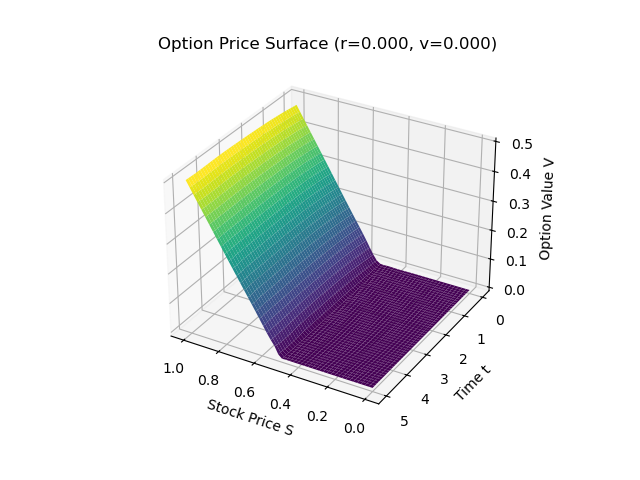

In [11]:
plot_surface(model, r_val=0., v_val=0.0)

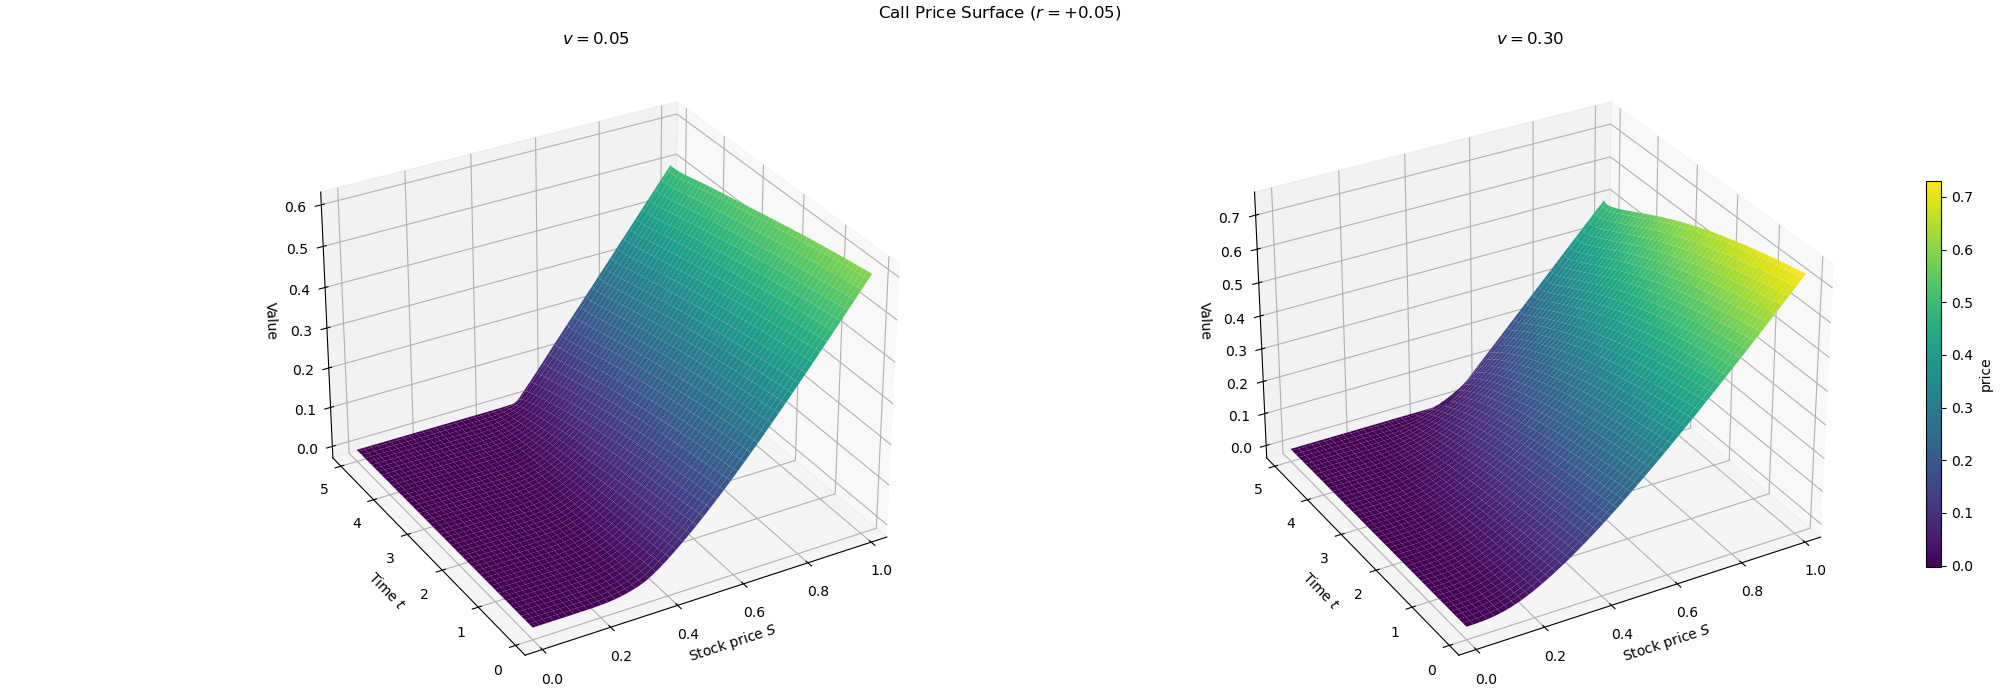

In [12]:
r_fixed      = 0.05            # rate held fixed in the 3-D slices
v_slices     = [0.05, 0.3] # three v values for the row of surfaces
spot_S       = STRIKE          # evaluate “at-the-money” (S = K)

# grids for the surfaces
n_t, n_s = 100, 100
t_grid   = torch.linspace(0.0, T, n_t, device=DEV, dtype=DTYPE)
s_grid   = torch.linspace(s_min, s_max, n_s, device=DEV, dtype=DTYPE)
T_mesh, S_mesh = torch.meshgrid(t_grid, s_grid, indexing='ij')


# ================================================================
# Helper for a single price
# ================================================================
def price_point(t, s, r, v):
    t_t = torch.tensor([t], device=DEV, dtype=DTYPE)
    s_t = torch.tensor([s], device=DEV, dtype=DTYPE)
    r_t = torch.tensor([r], device=DEV, dtype=DTYPE)
    v_t = torch.tensor([v], device=DEV, dtype=DTYPE)
    return model_price(model, t_t, s_t, r_t, v_t).item()


from matplotlib import cm, colors
def pad(lo, hi, pct=0.05):
    span = hi - lo
    return lo - pct*span, hi + pct*span

# first pass – evaluate model on each (t,S) grid so we know global colour limits
V_meshes, vmin, vmax = [],  +np.inf, -np.inf
for v_fixed in v_slices:
    r_mesh = torch.full_like(T_mesh.flatten(), r_fixed, device=DEV, dtype=DTYPE)
    v_mesh = torch.full_like(T_mesh.flatten(), v_fixed, device=DEV, dtype=DTYPE)
    with torch.no_grad():
        V = model_price(model,
                        T_mesh.flatten(), S_mesh.flatten(),
                        r_mesh, v_mesh).reshape(T_mesh.shape)
    V_meshes.append(V)
    vmin = min(vmin, V.min().item())
    vmax = max(vmax, V.max().item())

# figure + three sub-axes (constrained so labels aren’t cut)
fig, axes = plt.subplots(1, 2, figsize=(20, 7),      # ← wider canvas
                         subplot_kw={'projection': '3d'},
                         constrained_layout=True)

for ax, v_fixed, V in zip(axes, v_slices, V_meshes):
    ax.view_init(elev=30, azim=-120)
    surf = ax.plot_surface(S_mesh.cpu().numpy(),
                           T_mesh.cpu().numpy(),
                           V.cpu().numpy(),
                           cmap='viridis', vmin=vmin, vmax=vmax,
                           linewidth=0, antialiased=True)
    ax.set_xlabel('Stock price $S$'); ax.set_ylabel('Time $t$'); ax.set_zlabel('Value')
    ax.set_title(rf'$v={v_fixed:.2f}$')
    ax.set_xlim(*pad(S_mesh.min().item(), S_mesh.max().item()))
    ax.set_ylim(*pad(T_mesh.min().item(), T_mesh.max().item()))
    ax.set_zlim(*pad(V.min().item(), V.max().item()))
# shared colour-bar ----------------------------------------------------------
norm = colors.Normalize(vmin=vmin, vmax=vmax)
sm   = cm.ScalarMappable(norm=norm, cmap='viridis')
sm.set_array([])
fig.colorbar(sm, ax=axes, shrink=0.6, aspect=25, pad=0.04, label='price')

# centred figure-wide title --------------------------------------------------
fig.suptitle(f'Call Price Surface ($r = {r_fixed:+.02f}$)')
plt.show()



/var/folders/cp/l432p0ns1t38qmnyr_3l3r000000gn/T/ipykernel_43769/658794656.py:19: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


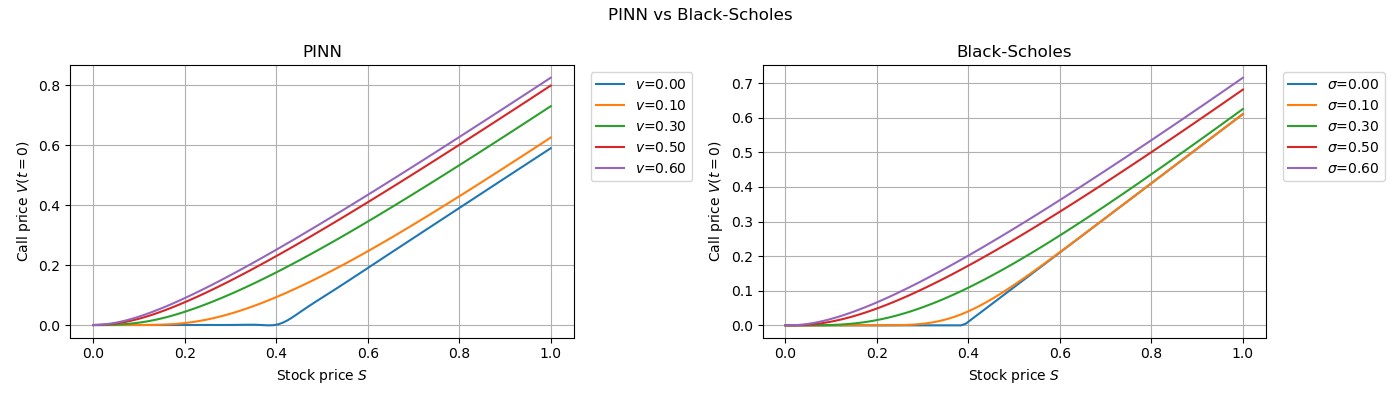

In [16]:
# =======================================================================
# (1)  σ-sweep  — its own figure
# =======================================================================
fig_sigma, (ax_pinn_vol, ax_bs_vol) = plt.subplots(1, 2, figsize=(14, 4))

# Define the stock price curve and initial time
s_curve = torch.linspace(s_min, s_max, 100, device=DEV, dtype=DTYPE)
t0 = torch.zeros_like(s_curve)

r_fixed_line = 0.05
v_plot       = [0.00, 0.10, 0.30, 0.50, 0.6]

for v in v_plot:
    # -------- PINN --------
    r_t = torch.full_like(s_curve, r_fixed_line, device=DEV, dtype=DTYPE)
    v_t = torch.full_like(s_curve, v,               device=DEV, dtype=DTYPE)
    pinn = model_price(model, t0, s_curve, r_t, v_t).cpu().numpy()
    ax_pinn_vol.plot(s_curve.cpu().numpy(), pinn, label=rf'$v$={v:.2f}')

    # -------- Black-Scholes --------
    bs = black_scholes_option_price(s_curve.cpu().numpy(), STRIKE, T,r=r_fixed_line, sigma=v)
    ax_bs_vol.plot(s_curve.cpu().numpy(), bs, label=rf'$\sigma$={v:.2f}')

# Cosmetics
for ax in (ax_pinn_vol, ax_bs_vol):
    ax.set_xlabel('Stock price $S$')
    ax.set_ylabel('Call price $V(t=0)$')
    ax.grid(True)
ax_pinn_vol.set_title('PINN'),  ax_bs_vol.set_title('Black-Scholes')
ax_pinn_vol.legend(loc='upper left', bbox_to_anchor=(1.02, 1.00))
ax_bs_vol  .legend(loc='upper left', bbox_to_anchor=(1.02, 1.00))

fig_sigma.suptitle('PINN vs Black-Scholes')
fig_sigma.tight_layout()
plt.show()

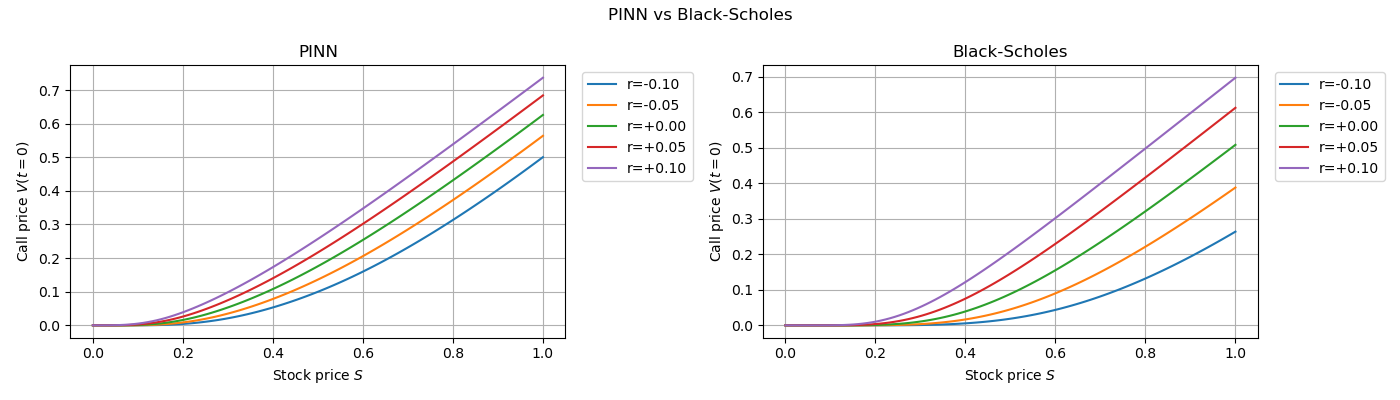

In [17]:
# =======================================================================
# (2)  r-sweep  — its own figure
# =======================================================================
fig_rate, (ax_pinn_r, ax_bs_r) = plt.subplots(1, 2, figsize=(14, 4))

v_fixed_line = 0.20
r_plot       = [-0.1, -0.05, 0.00, 0.05, 0.1]

for r in r_plot:
    # -------- PINN --------
    r_t = torch.full_like(s_curve, r,               device=DEV, dtype=DTYPE)
    v_t = torch.full_like(s_curve, v_fixed_line,    device=DEV, dtype=DTYPE)
    pinn = model_price(model, t0, s_curve, r_t, v_t).cpu().numpy()
    ax_pinn_r.plot(s_curve.cpu().numpy(), pinn, label=rf'r={r:+.2f}')

    # -------- Black-Scholes --------
    bs = black_scholes_option_price(s_curve.cpu().numpy(), STRIKE, T, r=r, sigma=v_fixed_line)
    ax_bs_r.plot(s_curve.cpu().numpy(), bs, label=rf'r={r:+.2f}')

# Cosmetics
for ax in (ax_pinn_r, ax_bs_r):
    ax.set_xlabel('Stock price $S$')
    ax.set_ylabel('Call price $V(t=0)$')
    ax.grid(True)
ax_pinn_r.set_title('PINN'),  ax_bs_r.set_title('Black-Scholes')
ax_pinn_r.legend(loc='upper left', bbox_to_anchor=(1.02, 1.00))
ax_bs_r  .legend(loc='upper left', bbox_to_anchor=(1.02, 1.00))

fig_rate.suptitle('PINN vs Black-Scholes')
fig_rate.tight_layout()
plt.show()


In [ ]:
def surface_S_vs_v(model,
                   tau_min=0.0, tau_max=1.0,
                   r_fixed=0.05,
                   n_s=100, n_v=100, n_tau=100):

    # ─── grids ───────────────────────────────────────────────
    s_vals  = torch.linspace(s_min, s_max,  n_s,   device=DEV, dtype=DTYPE)
    v_vals  = torch.linspace(0.2, 0.7,  n_v,   device=DEV, dtype=DTYPE)
    tau_vals= torch.linspace(tau_min, tau_max, n_tau, device=DEV, dtype=DTYPE)

    S_mesh, V_mesh, Tau_mesh = torch.meshgrid(s_vals, v_vals, tau_vals,
                                              indexing='ij')

    # flatten once for both models
    tau_flat = Tau_mesh.flatten()
    t_flat   = (1.0 - tau_flat) * T          # ← calendar time for pricing
    s_flat   = S_mesh.flatten()
    v_flat   = V_mesh.flatten()
    r_flat   = torch.full_like(tau_flat, r_fixed)

    # ─── PINN ────────────────────────────────────────────────
    with torch.no_grad():
        pinn = model_price(model, t_flat, s_flat, r_flat, v_flat)
    pinn = pinn.reshape(S_mesh.shape).cpu().numpy()

    # ─── Black–Scholes ──────────────────────────────────────
    bs = black_scholes_option_price(
            S     = s_flat.cpu().numpy(),
            K     = STRIKE,
            T     = t_flat.cpu().numpy(),
            r     = r_fixed,
            sigma = v_flat.cpu().numpy()
         ).reshape(S_mesh.shape)

    # ─── plot (τ on z-axis for clarity) ─────────────────────
    fig = plt.figure(figsize=(15, 6))
    for ax, data, title in zip((121, 122), (pinn, bs),
                               ('PINN', 'Black-Scholes')):
        ax = fig.add_subplot(ax, projection='3d')
        ax.plot_surface(S_mesh[:, :, 0].cpu().numpy(),   # S
                        V_mesh[:, :, 0].cpu().numpy(),   # v0
                        data.mean(axis=2),               # average over τ
                        cmap='viridis', edgecolor='none')
        ax.set_xlabel('Stock $S$')
        ax.set_ylabel('Volatility')
        ax.set_zlabel('Price $V$')
        ax.view_init(elev=30, azim=-120)

        ax.set_title(title)
    fig.suptitle(f'Surface  $V(S,v)$ '
                 f'(r fixed = {r_fixed:+.2f})')
    plt.tight_layout()
    plt.show()


In [ ]:
def surface_S_vs_r(model,
                   tau_min=0.0, tau_max=1.0,
                   v_fixed=0.20,
                   n_s=100, n_r=100, n_tau=100):

    # ─── grids ───────────────────────────────────────────────
    s_vals  = torch.linspace(s_min, s_max,  n_s,   device=DEV, dtype=DTYPE)
    r_vals  = torch.linspace(-0.1, 0.1,  n_r,   device=DEV, dtype=DTYPE)
    tau_vals= torch.linspace(tau_min, tau_max, n_tau, device=DEV, dtype=DTYPE)

    S_mesh, R_mesh, Tau_mesh = torch.meshgrid(s_vals, r_vals, tau_vals,
                                              indexing='ij')

    tau_flat = Tau_mesh.flatten()
    t_flat   = (1.0 - tau_flat) * T
    s_flat   = S_mesh.flatten()
    r_flat   = R_mesh.flatten()
    v_flat   = torch.full_like(tau_flat, v_fixed)

    # ─── PINN ────────────────────────────────────────────────
    with torch.no_grad():
        pinn = model_price(model, t_flat, s_flat, r_flat, v_flat)
    pinn = pinn.reshape(S_mesh.shape).cpu().numpy()

    # ─── Black–Scholes ──────────────────────────────────────
    bs = black_scholes_option_price(
            S     = s_flat.cpu().numpy(),
            K     = STRIKE,
            T     = t_flat.cpu().numpy(),
            r     = r_flat.cpu().numpy(),
            sigma = v_fixed
         ).reshape(S_mesh.shape)

    # ─── plot ───────────────────────────────────────────────
    fig = plt.figure(figsize=(15, 6))
    for ax, data, title in zip((121, 122), (pinn, bs),
                               ('PINN', 'Black-Scholes')):
        ax = fig.add_subplot(ax, projection='3d')
        ax.plot_surface(S_mesh[:, :, 0].cpu().numpy(),   # S
                        R_mesh[:, :, 0].cpu().numpy(),   # r0
                        data.mean(axis=2),               # average over τ
                        cmap='plasma', edgecolor='none')
        ax.set_xlabel('Stock $S$')
        ax.set_ylabel('Rate $r$')
        ax.view_init(elev=30, azim=-120)

        ax.set_zlabel('Price $V$')
        ax.set_title(title)
    fig.suptitle(f'Surface  $V(S,r)$'
                 f'($\sigma$ fixed = {v_fixed:.2f})')
    plt.tight_layout()
    plt.show()


/var/folders/cp/l432p0ns1t38qmnyr_3l3r000000gn/T/ipykernel_30530/658794656.py:19: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


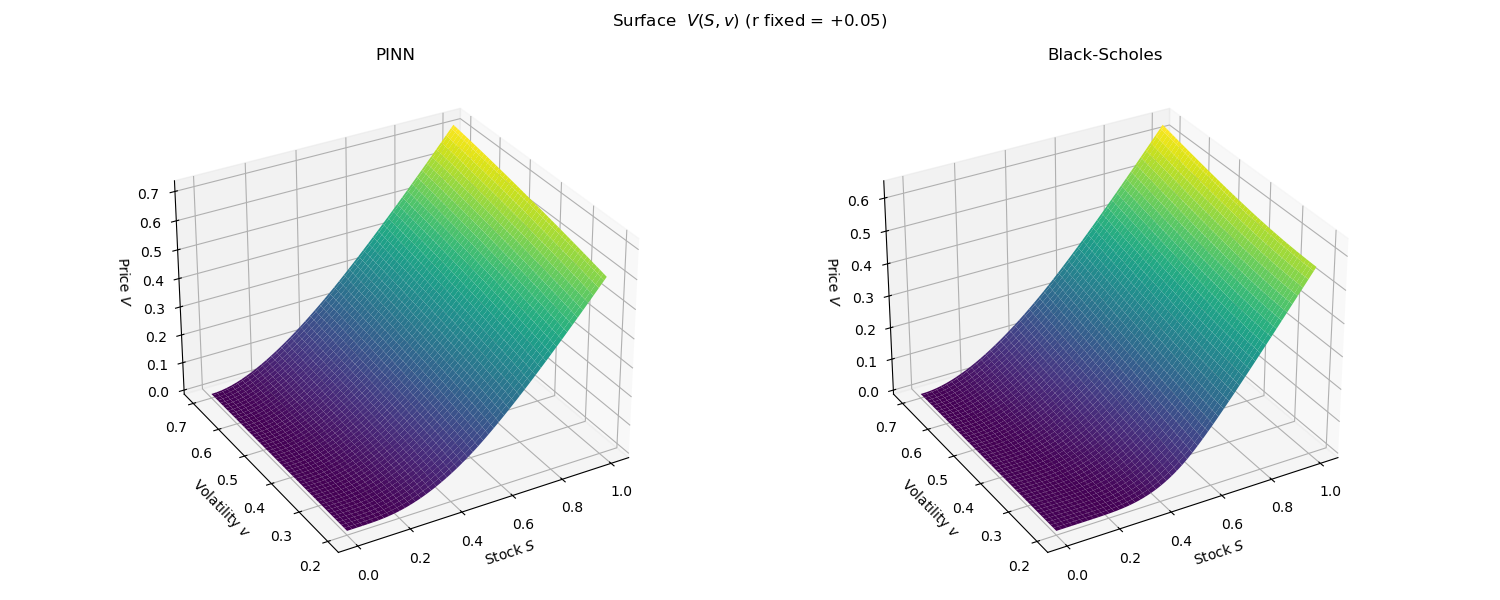

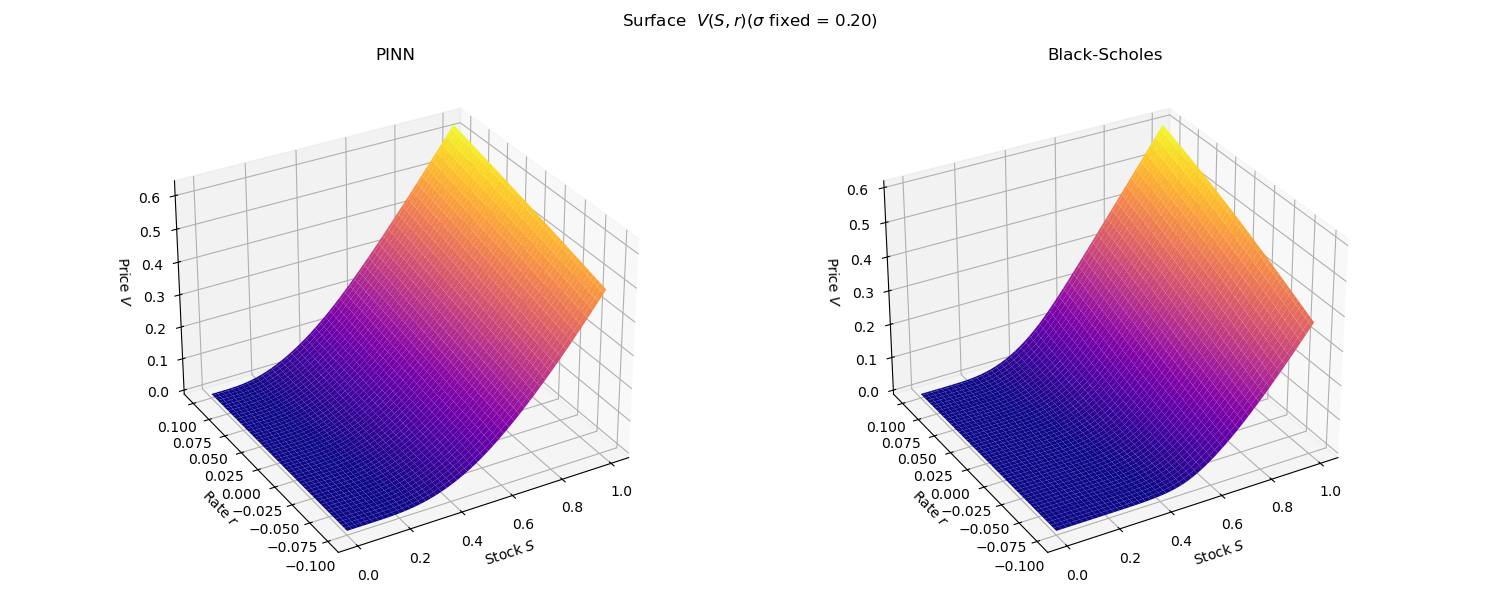

In [ ]:
surface_S_vs_v(model, r_fixed=0.05)
surface_S_vs_r(model, v_fixed=0.20)